# Chapter 1 - Euler's Method of Integration

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

## Getting to orbit with the rocket equation

I'd like to take a look at how to model a rocket taking off from ground level. I'll start off simply, with a rocket going straight up using the rocket equation to derive the force on the rocket. I'll use SpaceX's Starship as an example, because why not.

Here's the physics I'll need to think about:
- The engines burn propellant, which decreases the mass over time, and subsequently changes the acceleration over time.
- Getting to orbit isn't just going straight up, it actually means going so fast that I fall around the Earth without ever hitting the ground. I want to end up burning pretty much perpendicular to the Earth surface at the end of everything, so the angle of attack during the course of the engine burns will have a significant impact on getting to a stable orbit.
- Orbits mean circles, so I'll eventually have to work in polar coordinates to implement the acceleration due to Earth's gravity in a reasonable way. 

Here's the information publicly available for Starship as of February, 2025:

- 9m diameter 
- Full stack weight of about 11,000,000 lbs
- First stage dry mass of between 350,000 and 440,000 lbs, with 7,500,000 lbs of propellant capacity
- Second stage dry mass of 220,000 lbs, with 3,300,000 lbs of propellant
- Raptor V2 - 2750 kN of thrust, 347s ISP 
    - From ISP we can get the exhaust velocity $v_e = I_{sp}\cdot g_0$ with $g_0$ being the acceleration due to gravity at sea level
        - $v_e = 347 \text{s} *9.81\frac{\text{m}}{\text{s}^2} \approx 3400$ m/s
    - We can also get mass flow rate from thrust and exhaust velocity $F = \dot{m}\cdot v_e$ to tell us how the mass will change over time while the engines burn 
        - $\dot{m} = \frac{F}{v_e} = \frac{2750000 \text{N}}{3400 \text{m/s}} \approx 808 \frac{\text{kg}}{\text{s}}$ 
- The second stage is powered by Raptor Vacuum engines - 2980 kN of thrust, 380s ISP
    - Exhaust velocity:
        - $v_e = 380\text{s}*9.81\frac{\text{m}}{\text{s}^2} \approx 3720$ m/s
    - Mass flow rate:
        - $\dot{m} = \frac{2980000 \text{N}}{3700 \text{m/s}} \approx 805 \frac{\text{kg}}{\text{s}}$ 
- And now I can determine burn time from the mass flow rates using $t_b = m / \dot{m}$  for both stages, remembering to multiply by 33 for the number of engines in the first stage, and 3 for the second:
    - Stage 1 burn time: 
        - $t_b = (7.5e6 \text{ lbs} *0.454\frac{\text{kg}}{\text{lbs}})  / (33*808\frac{\text{kg}}{\text{s}}) = 128$ seconds
    - Stage 2 burn time: 
        - $t_b = (3.3e6*0.454) / 3*805 = 618$ seconds  

### The process
Here's the steps to getting to orbit via Python:
- I'll start in 1 dimension, with the rocket just going straight up. 
- From there, I'll add in a simple model for aerodynamic drag, and make it more complex as needed. 
- Next, I'll move to 2 dimensions and begin adjusting the pitch angle of the rocket over time. I'll do this for the first stage.
- Once I have the first stage burning to where I expect, I'll pick up right there with the second stage and switch to polar coordinates for calculating the orbit.

I'll need to think about the force from the rocket engines, but also how the mass is changing over time due to fuel expenditure. We'll do it in a vacuum, first, so our equation of motion is $$ \frac{d}{dt}(mv) = T - mg $$ Where T is the thrust provided by the engines. $$T = \dot{m}v_{ex} $$ with $\dot{m}$ as the mass loss rate and $v_{ex}$ as the exhaust velocity of the engines. Differentiating the momentum on the left side of our equation of motion, $p=mv$, we get $$ m\frac{dv}{dt} + \dot{m}v = \dot{m}v_{ex} - mg $$ so that $$ \frac{dv}{dt} = \frac{\dot{m}}{m}(v_{ex}-v)-g $$

Alright, I'll get started by defining general parameters for Starship and the Earth and other variables needed.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## Define Starship parameters
# Mass and propellant
mass_total = 1.1e7 * 0.45359           # lbs to kg
propload_stage1 = 7.5e6 * 0.45359     # lbs to kg
mass_stage2_total = 3.45e6 * 0.45359        # lbs to kg
propload_stage2 = 3.3e6 * 0.45359     # lbs to kg

# Physical attributes
diameter = 9                                # meters
cross_section = np.pi * (diameter / 2)**2   # m^2
drag_coef = 0.35                             # for a blunt cone going in the direction of travel

# Engine attributes:
N_engines_stage1 = 33
N_engines_stage2 = 3
v_exhaust_stage1 = 3400                             # m/s
v_exhaust_stage2 = 3720                             # m/s
mdot_stage1 = 808 * N_engines_stage1                # kg/s
mdot_stage2 = 805 * N_engines_stage2                # kg/s 
burntime_stage1 = propload_stage1 / mdot_stage1     # seconds
burntime_stage2 = propload_stage2 / mdot_stage2     # seconds    

# Physical attributes for Earth
g0 = 9.81                 # acceleration due to gravity at Earth surface (m/s^2)
GM = 3.986004418e14       # Earth's gravitational parameter (m^3/s^2)
radius_earth = 6.371e6    # Earth radius in meters
rho = 1.225               # air density at sea level (kg/m^3)
rho_20km = 0.089          # air density at 20 km altitude (kg/m^3)
rho_50km = 0.001          # air density at 50km altitude (kg/m^3) 
v_rot = (2*np.pi*radius_earth) / 86400 # Rotational velocity at Earth surface on equator
iss_vel_orb = np.sqrt(GM / (radius_earth + 420e3)) # velocity required to stay on ISS orbit (if it were in an equatorial orbit)

# Delta v calculations
delta_v_stage1 = v_exhaust_stage1 * np.log(mass_total / (mass_total - propload_stage1))
delta_v_stage2 = v_exhaust_stage2 * np.log(mass_stage2_total / (mass_stage2_total - propload_stage2))
total_delta_v = delta_v_stage1 + delta_v_stage2
print("Stage 1 ΔV:", delta_v_stage1)
print("Stage 2 ΔV:", delta_v_stage2)
print("Total ΔV:", total_delta_v)  # Should be > 9300 m/s


Stage 1 ΔV: 3893.449834630209
Stage 2 ΔV: 11664.038483256436
Total ΔV: 15557.488317886644


# The first dimension

In line with Chapter 1 of Computational Physics by Giordani and Nakanishi, I'll use Euler's method of integration to loop through a certain number of time steps and calculate a new velocity, and now mass, for each point in time. 

### In a vacuum

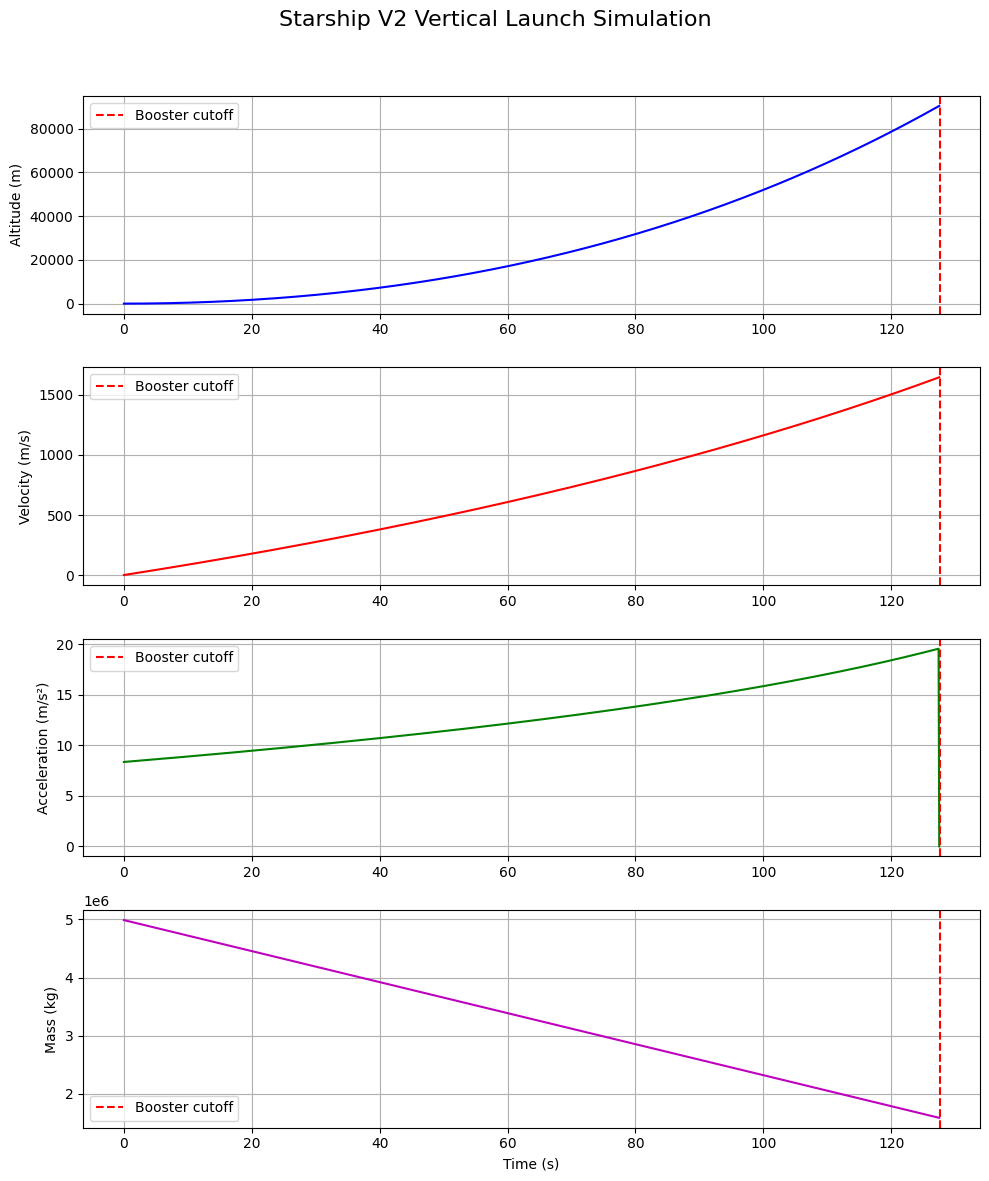

In [4]:
# Define time step and number of steps
dt = 0.1
n_steps_stage1 = int(burntime_stage1 / dt) # number of steps needed to cover stage 1 burntime with the set time interval

# Initialize arrays
t_stage1   = np.zeros(n_steps_stage1 + 1)  # time (s)
pos_stage1 = np.zeros(n_steps_stage1 + 1)  # altitude (m)
v_stage1   = np.zeros(n_steps_stage1 + 1)  # velocity (m/s)
a_stage1   = np.zeros(n_steps_stage1 + 1)  # acceleration (m/s²)
m_stage1   = np.zeros(n_steps_stage1 + 1)  # mass (kg)

# Set initial conditions
t_stage1[0]   = 0.0
pos_stage1[0] = 0.0   # launch from ground level
v_stage1[0]   = 0.0
m_stage1[0]   = mass_total

# Use a for loop to update time, acceleration, velocity, position and velocity while accounting for the mass loss rate
for i in range(n_steps_stage1):
    t_stage1[i+1] = t_stage1[i] + dt

    # Run this only when engines are burning
    if t_stage1[i] < burntime_stage1:

        # Total thrust contribution
        a_stage1[i] = (mdot_stage1 / m_stage1[i]) * (v_exhaust_stage1 - v_stage1[i]) - g0

        # Update mass
        m_stage1[i+1] = m_stage1[i] - mdot_stage1*dt

    else: 
        a_stage1[i] = -g
        m_stage1[i+1] = m_stage1[i]

    # Update veloicty using Euler integration
    v_stage1[i+1] = v_stage1[i] + a_stage1[i]*dt 

    # Update position
    pos_stage1[i+1] = pos_stage1[i] + v_stage1[i]*dt + 0.5*a_stage1[i]*dt**2

# Plot
fig, axs = plt.subplots(4, 1, figsize=(10, 12))

# Altitude plot
axs[0].plot(t_stage1, pos_stage1, 'b-')
axs[0].set_ylabel('Altitude (m)')
axs[0].axvline(x=burntime_stage1, linestyle='--', color='red', label='Booster cutoff')
axs[0].legend()
axs[0].grid(True)

# Velocity plot
axs[1].plot(t_stage1, v_stage1, 'r-')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].axvline(x=burntime_stage1, linestyle='--', color='red', label='Booster cutoff')
axs[1].legend()
axs[1].grid(True)

# Acceleration plot
axs[2].plot(t_stage1, a_stage1, 'g-')
axs[2].set_ylabel('Acceleration (m/s²)')
axs[2].axvline(x=burntime_stage1, linestyle='--', color='red', label='Booster cutoff')
axs[2].legend()
axs[2].grid(True)

# Mass plot
axs[3].plot(t_stage1, m_stage1, 'm-')
axs[3].set_ylabel('Mass (kg)')
axs[3].set_xlabel('Time (s)')
axs[3].axvline(x=burntime_stage1, linestyle='--', color='red', label='Booster cutoff')
axs[3].legend()
axs[3].grid(True)

fig.suptitle('Starship V2 Vertical Launch Simulation', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Adding in drag

I'll now factor in drag like I did previously in the Ch1 examples, but updating for mass loss to see how that affects things.

C:\Users\smick\AppData\Local\Temp\ipykernel_37548\3950153507.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axs[0].plot(t_stage1, pos_stage1, 'b-', color='grey', label='without drag')
C:\Users\smick\AppData\Local\Temp\ipykernel_37548\3950153507.py:65: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axs[2].plot(t_stage1, a_stage1, 'b-', color='grey', label='without drag')
C:\Users\smick\AppData\Local\Temp\ipykernel_37548\3950153507.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axs[3].plot(t_stage1, m_stage1, 'b-', color='grey', label='without drag')


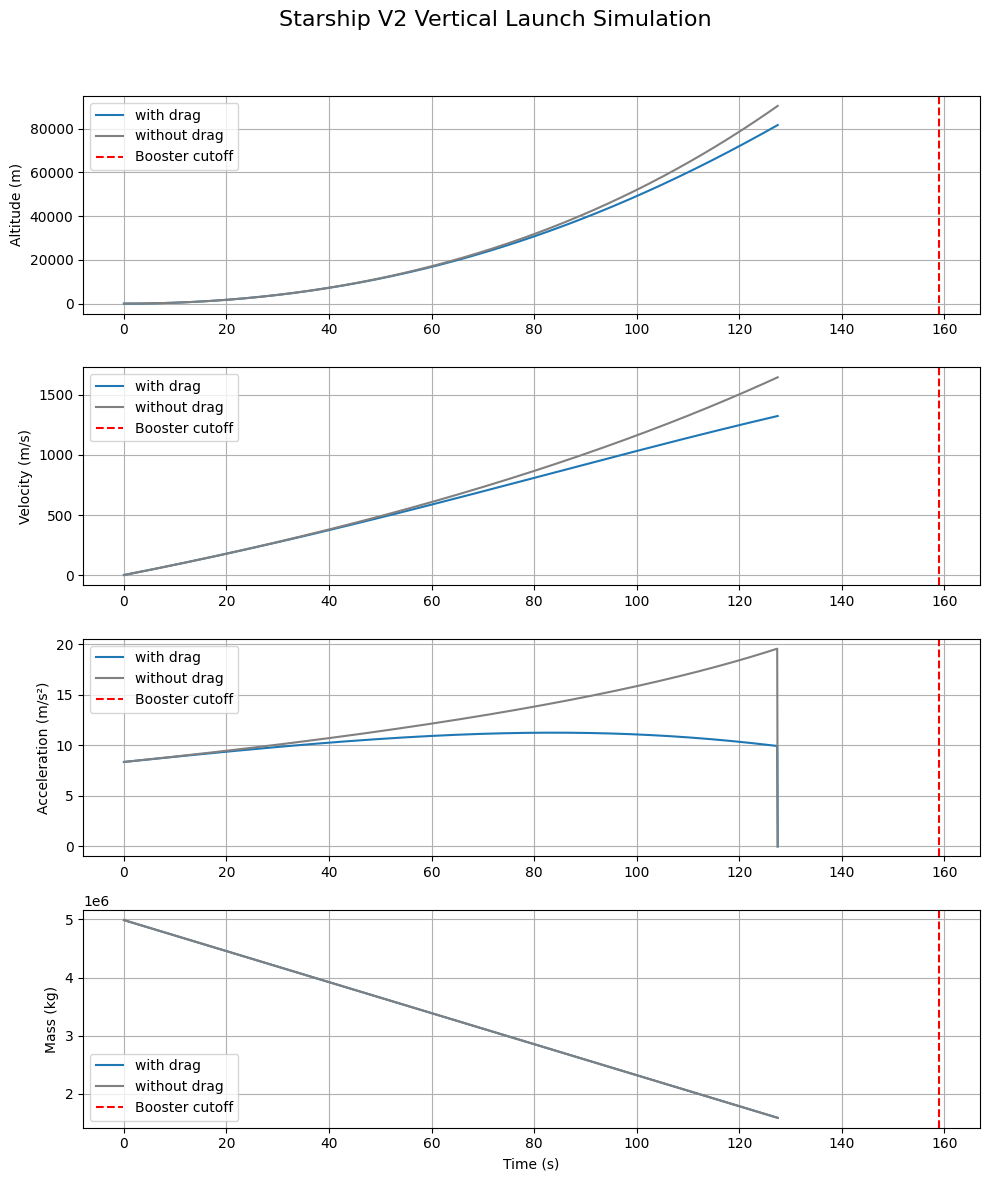

In [5]:
# Initialize arrays
t_stage1_w_drag   = np.zeros(n_steps_stage1 + 1)  # time (s)
pos_stage1_w_drag = np.zeros(n_steps_stage1 + 1)  # altitude (m)
v_stage1_w_drag   = np.zeros(n_steps_stage1 + 1)  # velocity (m/s)
a_starship_w_drag   = np.zeros(n_steps_stage1 + 1)  # acceleration (m/s²)
m_starship_w_drag   = np.zeros(n_steps_stage1 + 1)  # mass (kg)

# Set initial conditions
t_stage1_w_drag[0]   = 0.0
pos_stage1_w_drag[0] = 0.0   # launch from ground level
v_stage1_w_drag[0]   = 0.0
m_starship_w_drag[0]   = mass_total
a_starship_w_drag[0] = 0

# Use a for loop to update time, acceleration, velocity, position and velocity while accounting for the mass loss rate
for i in range(n_steps_stage1):
    t_stage1_w_drag[i+1] = t_stage1_w_drag[i] + dt

    # Use current starship mass and velocity to calculate instantaneous acceleration from drag
    drag_acc = -0.5 * (rho * drag_coef * cross_section / m_starship_w_drag[i]) * v_stage1_w_drag[i] * abs(v_stage1_w_drag[i])

    # Run this only when engines are burning
    if t_stage1_w_drag[i] < burntime_stage1:

        # Thrust acceleration
        thrust_acc = (mdot_stage1 / m_starship_w_drag[i]) * (v_exhaust_stage1 - v_stage1_w_drag[i]) 

        # Total thrust contribution
        a_starship_w_drag[i] = thrust_acc + drag_acc - g0

        # Update mass
        m_starship_w_drag[i+1] = m_starship_w_drag[i] - mdot_stage1* dt

    else: 
        a_starship_w_drag[i] = -g + drag_acc
        m_starship_w_drag[i+1] = m_starship_w_drag[i]

    # Update velocity using Euler integration
    v_stage1_w_drag[i+1] = v_stage1_w_drag[i] + a_starship_w_drag[i]*dt 

    # Update position
    pos_stage1_w_drag[i+1] = pos_stage1_w_drag[i] + v_stage1_w_drag[i]*dt + 0.5*a_starship_w_drag[i]*dt**2

# Plot
fig, axs = plt.subplots(4, 1, figsize=(10, 12))

# Altitude plot
axs[0].plot(t_stage1_w_drag, pos_stage1_w_drag, label='with drag')
axs[0].plot(t_stage1, pos_stage1, 'b-', color='grey', label='without drag')
axs[0].set_ylabel('Altitude (m)')
axs[0].axvline(x=159, linestyle='--', color='red', label='Booster cutoff')
axs[0].legend()
axs[0].grid(True)

# Velocity plot
axs[1].plot(t_stage1_w_drag, v_stage1_w_drag, label='with drag')
axs[1].plot(t_stage1, v_stage1, color='grey', label='without drag')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].axvline(x=159, linestyle='--', color='red', label='Booster cutoff')
axs[1].legend()
axs[1].grid(True)

# Acceleration plot
axs[2].plot(t_stage1_w_drag, a_starship_w_drag, label='with drag')
axs[2].plot(t_stage1, a_stage1, 'b-', color='grey', label='without drag')
axs[2].set_ylabel('Acceleration (m/s²)')
axs[2].axvline(x=159, linestyle='--', color='red', label='Booster cutoff')
axs[2].legend()
axs[2].grid(True)

# Mass plot
axs[3].plot(t_stage1_w_drag, m_starship_w_drag, label='with drag')
axs[3].plot(t_stage1, m_stage1, 'b-', color='grey', label='without drag')
axs[3].set_ylabel('Mass (kg)')
axs[3].set_xlabel('Time (s)')
axs[3].axvline(x=159, linestyle='--', color='red', label='Booster cutoff')
axs[3].legend()
axs[3].grid(True)

fig.suptitle('Starship V2 Vertical Launch Simulation', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Modeling drag as a function of altitude

The acceleration actually decreases over time, which is mostly inaccurate due to using a constant value for air pressure at sea level. I'll adjust that this time by using a simple scalar to decrease the air pressure over time to what is expected at about 50km.

We can modify the density, so that the drag force should decrease as Starship reaches higher altitudes. $$\rho(z) = \rho_0 e^{-z/H}$$
Where z is the altitude, and H is the characteristic distance over which the atmospheric density decreases by a factor of $e$.

C:\Users\smick\AppData\Local\Temp\ipykernel_37548\1641573051.py:57: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axs[0].plot(t_stage1, pos_stage1, 'b-', color='grey', label='without drag')
C:\Users\smick\AppData\Local\Temp\ipykernel_37548\1641573051.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axs[2].plot(t_stage1, a_stage1, 'b-', color='grey', label='without drag')
C:\Users\smick\AppData\Local\Temp\ipykernel_37548\1641573051.py:81: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axs[3].plot(t_stage1, m_stage1, 'b-', color='grey', label='without drag')


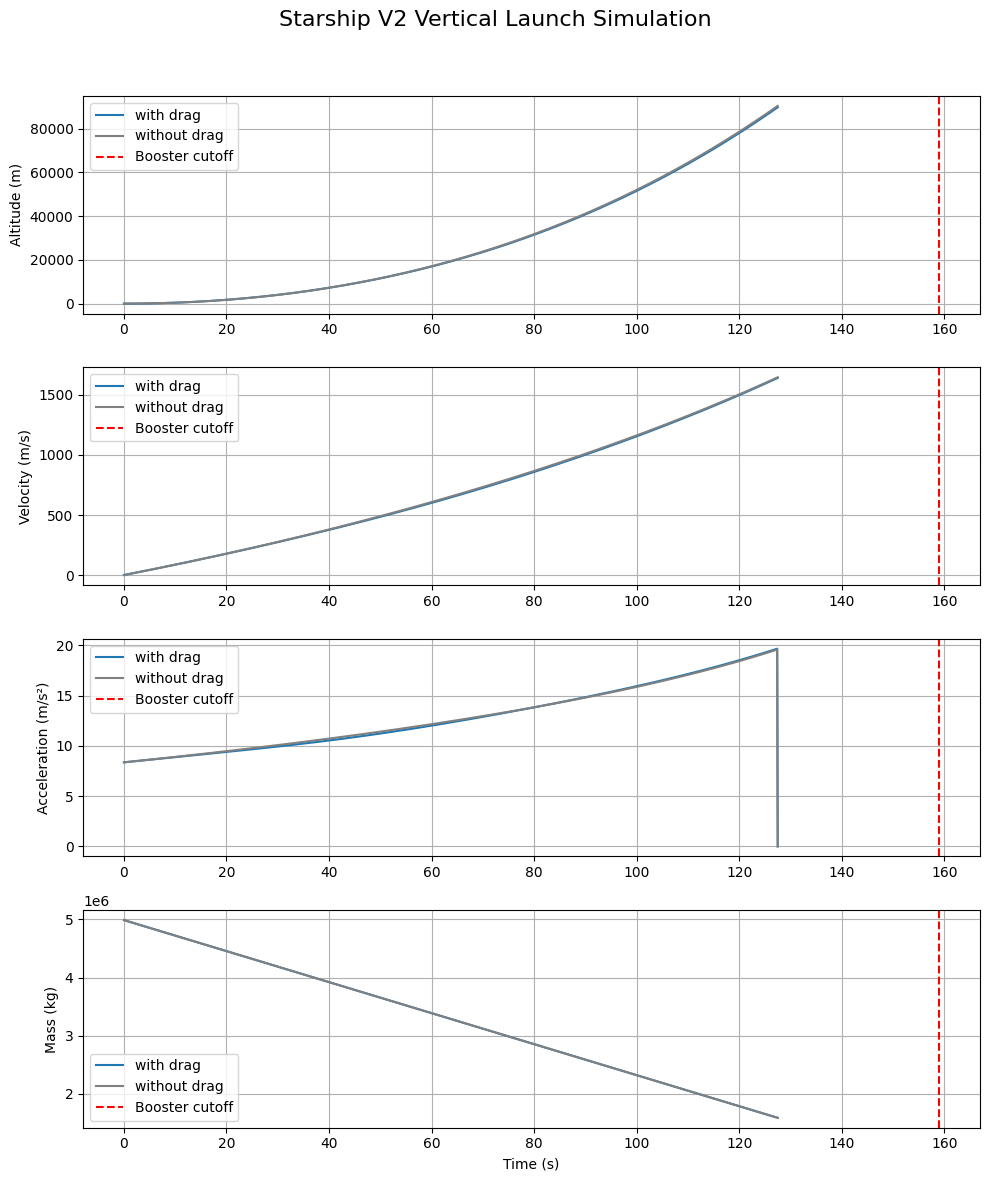

In [6]:
# Define scale height
scale_height = 8500       # meters

# Initialize arrays
t_stage1_w_drag   = np.zeros(n_steps_stage1 + 1)  # time (s)
pos_stage1_w_drag = np.zeros(n_steps_stage1 + 1)  # altitude (m)
v_starship_w_drag   = np.zeros(n_steps_stage1 + 1)  # velocity (m/s)
a_starship_w_drag   = np.zeros(n_steps_stage1 + 1)  # acceleration (m/s²)
m_starship_w_drag   = np.zeros(n_steps_stage1 + 1)  # mass (kg)
drag_starship       = np.zeros(n_steps_stage1 + 1)  # Newtons (N) 

# Set initial conditions
t_stage1_w_drag[0]   = 0.0
pos_stage1_w_drag[0] = 0.0   # launch from ground level
v_starship_w_drag[0]   = 0.0
m_starship_w_drag[0]   = mass_total
a_starship_w_drag[0] = 0
drag_starship[0] = 0

# Use a for loop to update time, acceleration, velocity, position and velocity while accounting for the mass loss rate
for i in range(n_steps_stage1):
    t_stage1_w_drag[i+1] = t_stage1_w_drag[i] + dt

    # Calculate current air density based on altitude
    air_density = rho* np.exp(-pos_stage1_w_drag[i] / scale_height)

    # Use current starship mass and velocity to calculate instantaneous acceleration from drag
    drag_starship[i] = -0.5 * (air_density * drag_coef * cross_section / m_starship_w_drag[i]) * v_starship_w_drag[i] * abs(v_starship_w_drag[i])

    # Run this only when engines are burning
    if t_stage1_w_drag[i] < burntime_stage1:

        # Thrust acceleration
        thrust_acc = (mdot_stage1 / m_starship_w_drag[i]) * (v_exhaust_stage1 - v_starship_w_drag[i]) 

        # Total thrust contribution
        a_starship_w_drag[i] = thrust_acc + drag_starship[i] - g0

        # Update mass
        m_starship_w_drag[i+1] = m_starship_w_drag[i] - mdot_stage1* dt

    else: 
        a_starship_w_drag[i] = -g + drag_starship[i]
        m_starship_w_drag[i+1] = m_starship_w_drag[i]

    # Update velocity using Euler integration
    v_starship_w_drag[i+1] = v_starship_w_drag[i] + a_starship_w_drag[i]*dt 

    # Update position
    pos_stage1_w_drag[i+1] = pos_stage1_w_drag[i] + v_starship_w_drag[i]*dt + 0.5*a_starship_w_drag[i]*dt**2

# Plot
fig, axs = plt.subplots(4, 1, figsize=(10, 12))

# Altitude plot
axs[0].plot(t_stage1_w_drag, pos_stage1_w_drag, label='with drag')
axs[0].plot(t_stage1, pos_stage1, 'b-', color='grey', label='without drag')
axs[0].set_ylabel('Altitude (m)')
axs[0].axvline(x=159, linestyle='--', color='red', label='Booster cutoff')
axs[0].legend()
axs[0].grid(True)

# Velocity plot
axs[1].plot(t_stage1_w_drag, v_starship_w_drag, label='with drag')
axs[1].plot(t_stage1, v_stage1, color='grey', label='without drag')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].axvline(x=159, linestyle='--', color='red', label='Booster cutoff')
axs[1].legend()
axs[1].grid(True)

# Acceleration plot
axs[2].plot(t_stage1_w_drag, a_starship_w_drag, label='with drag')
axs[2].plot(t_stage1, a_stage1, 'b-', color='grey', label='without drag')
axs[2].set_ylabel('Acceleration (m/s²)')
axs[2].axvline(x=159, linestyle='--', color='red', label='Booster cutoff')
axs[2].legend()
axs[2].grid(True)

# Mass plot
axs[3].plot(t_stage1_w_drag, m_starship_w_drag, label='with drag')
axs[3].plot(t_stage1, m_stage1, 'b-', color='grey', label='without drag')
axs[3].set_ylabel('Mass (kg)')
axs[3].set_xlabel('Time (s)')
axs[3].axvline(x=159, linestyle='--', color='red', label='Booster cutoff')
axs[3].legend()
axs[3].grid(True)

fig.suptitle('Starship V2 Vertical Launch Simulation', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Moving to 2D

Now that I have a realistic model of Starship going straight upwards, I'd like to make it go eventually go around the Earth. That means we need some more dimensions, so I'll start with adding in a second dimension to our first stage of the launch. 

Here's what I have to change or add:

- Pitch angle
    - From the flight 5 test footage, it looks like the booster separates when it is at roughly between 45 and 60 degrees off of the vertical. I'll use 45 degrees to start with, and for convenience I'll say that its a constant change in angle. 
- 2D arrays
    - Position, velocity, acceleration, thrust arrays that hold x,y coordinates


### Stage 1

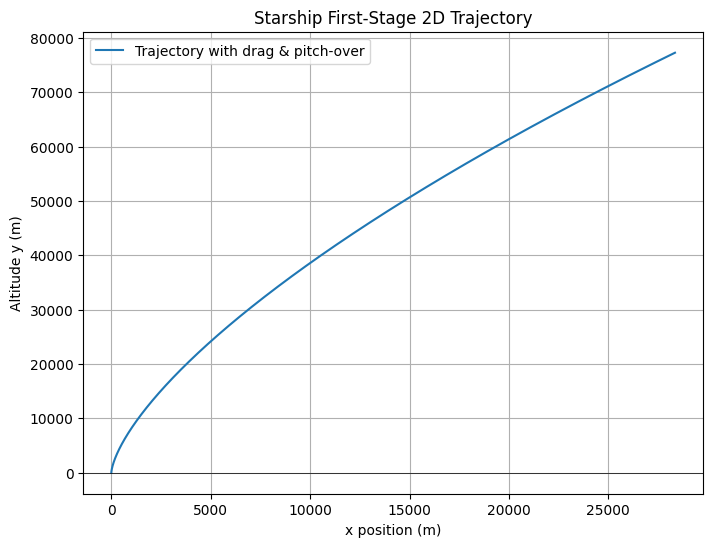

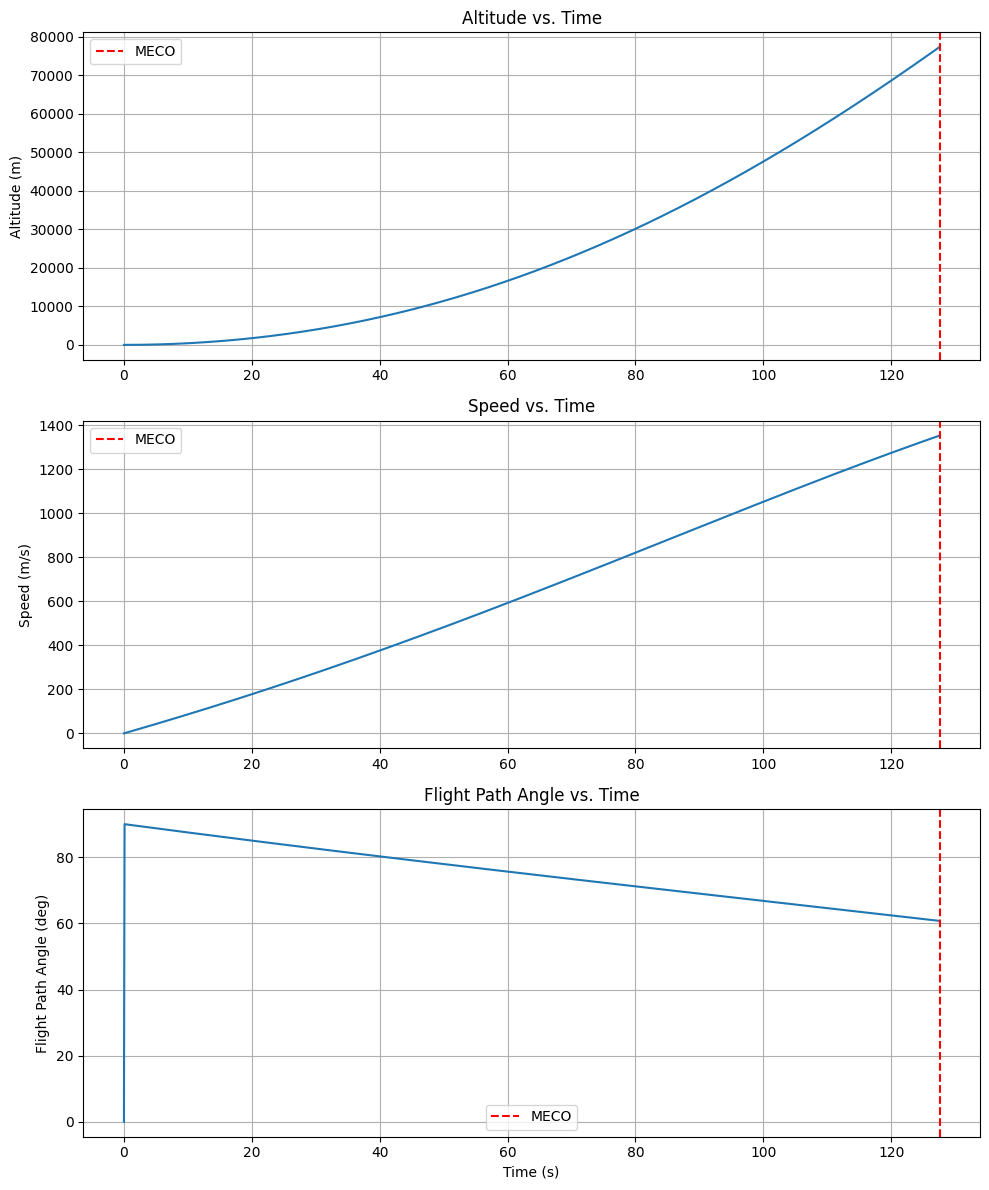

In [7]:
# Time and m_stage1 are still scalar arrays
t_stage1 = np.zeros(n_steps_stage1+1)         # time (s)
m_stage1 = np.zeros(n_steps_stage1+1)      # kg

# Position, velocity, acceleration arrays are now 2D (columns: [x, y])
pos_stage1 = np.zeros((n_steps_stage1+1, 2))    # position (m)
vel_stage1 = np.zeros((n_steps_stage1+1, 2))    # velocity (m/s)
acc_stage1 = np.zeros((n_steps_stage1+1, 2))    # acceleration (m/s²)

# Set the final angle off the vertical to traverse to by the end of the burn time
pitch_final_stage1 = 30

# Set initial conditions 
t_stage1[0] = 0.0
pos_stage1[0] = np.array([0.0, 0.0])   # Launch from ground at x=0, y=0
vel_stage1[0] = np.array([0.0, 0.0])   # Starting at rest
m_stage1[0] = mass_total
acc_stage1[0] = np.array([0.0, 0.0])

# Main loop for Euler integration as before, but with quite a few more steps
for i in range(n_steps_stage1):

    # Update time
    t_stage1[i+1] = t_stage1[i] + dt

    # Update pitch angle so at t_stage1=0 it's 0 degrees off vertical
    # and at t_stage1= burn time it is at the final pitch angle
    pitch_deg = (pitch_final_stage1/burntime_stage1) * t_stage1[i]
    pitch_rad = np.deg2rad(pitch_deg) # convert to rad for use in cos and sin functions

    # Compute thrust unit vector by measuring current angle from vertical
    thrust_unit = np.array([np.sin(pitch_rad), np.cos(pitch_rad)])

    # Compute current speed for use in the drag equation
    speed = np.linalg.norm(vel_stage1[i])
    if speed > 0:
        # Drag force 
        drag_acc = -0.5 * (rho * drag_coef * cross_section / m_stage1[i]) * speed * vel_stage1[i]

        # No drag if there's no speed
    else:
        drag_acc = np.array([0.0,0.0])

    # Compute thrust acceleration while the engines are burning
    if t_stage1[i] < burntime_stage1:
        # Use the dot product of the velocity vector and the unit vector 
        # to determine the amount of thrust along the velocity vector
        thrust_along_v = np.dot(vel_stage1[i], thrust_unit)
        
        # Calculate acceleration from thrust
        thrust_acc = (mdot_stage1 / m_stage1[i]) * (v_exhaust_stage1 - thrust_along_v)* thrust_unit

        # Update m_stage1
        m_stage1[i+1] = m_stage1[i] - mdot_stage1*dt
    
    else:
        thrust_acc = np.array([0.0,0.0])
        m_stage1[i+1] = m_stage1[i]
    
    # Gravitational acceleration is constant in the y direction
    grav_acc = np.array([0.00,-9.81])

    # Total acceleration is then the sum of the three accelerations
    acc_stage1[i] = thrust_acc + drag_acc + grav_acc

    # Use Euler Integration like before for the velocity and position vectors
    vel_stage1[i+1] = vel_stage1[i] + acc_stage1[i]*dt
    pos_stage1[i+1] = pos_stage1[i] + vel_stage1[i]*dt + 0.5*acc_stage1[i]*dt**2


# Trajectory plot: x vs. y
plt.figure(figsize=(8, 6))
plt.plot(pos_stage1[:,0], pos_stage1[:,1], label='Trajectory with drag & pitch-over')
plt.xlabel('x position (m)')
plt.ylabel('Altitude y (m)')
plt.title('Starship First-Stage 2D Trajectory')
plt.axhline(0, color='k', linewidth=0.5)  # ground line
plt.grid(True)
plt.legend()
plt.show()

# Plot time histories of altitude, speed, etc.
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Altitude vs. time
axs[0].plot(t_stage1, pos_stage1[:,1])
axs[0].set_ylabel('Altitude (m)')
axs[0].set_title('Altitude vs. Time')
axs[0].axvline(x=burntime_stage1, linestyle='--', color='red', label='MECO')
axs[0].legend()
axs[0].grid(True)

# Speed vs. time
speed_history = np.linalg.norm(vel_stage1, axis=1)
axs[1].plot(t_stage1, speed_history)
axs[1].set_ylabel('Speed (m/s)')
axs[1].set_title('Speed vs. Time')
axs[1].axvline(x=burntime_stage1, linestyle='--', color='red', label='MECO')
axs[1].legend()
axs[1].grid(True)

# Flight path angle vs. time (computed from velocity)
# Note: flight path angle measured from horizontal = arctan(v_y/v_x)
flight_angles = np.degrees(np.arctan2(vel_stage1[:,1], vel_stage1[:,0]))
axs[2].plot(t_stage1, flight_angles)
axs[2].set_ylabel('Flight Path Angle (deg)')
axs[2].set_xlabel('Time (s)')
axs[2].axvline(x=burntime_stage1, linestyle='--', color='red', label='MECO')
axs[2].legend()
axs[2].set_title('Flight Path Angle vs. Time')
axs[2].grid(True)

plt.tight_layout()
plt.show()



Looking at the footage from Starship's 5th test flight, separation looks like it happens right around 2:39 and at 68km altitude, so this is close! 

Now that I have a booster separation event that I like, I'd like to now see how the second stage fares. I'll pick the velocity vector right up from where it leaves off at the end of the previous run, but I'll have to update parameters for the mass and thrust, and I'll go ahead and assume drag is negligible from here on out. 

Oh, and now orbital mechanics come into play. We now need to consider polar coordinates, and calculate the position as a function of radius from the center of the Earth.

### Stage 2

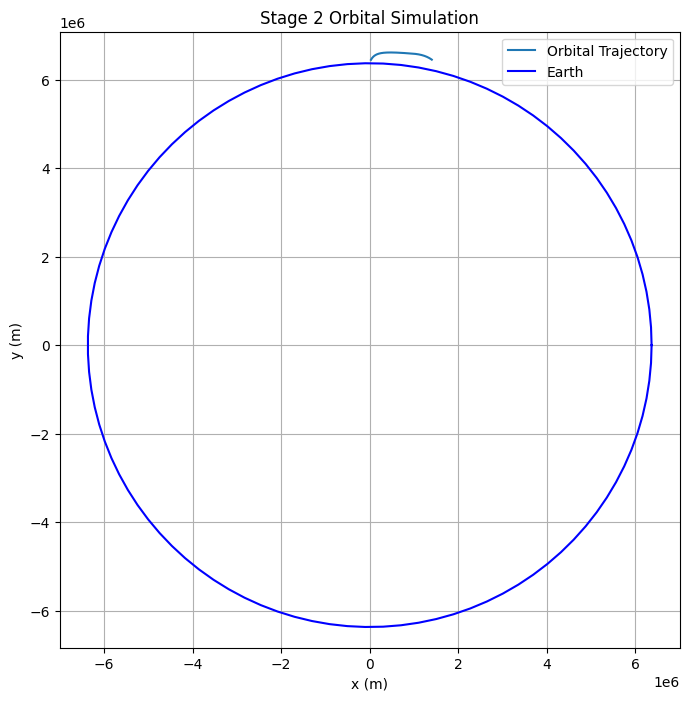

(0.0, 510.0)

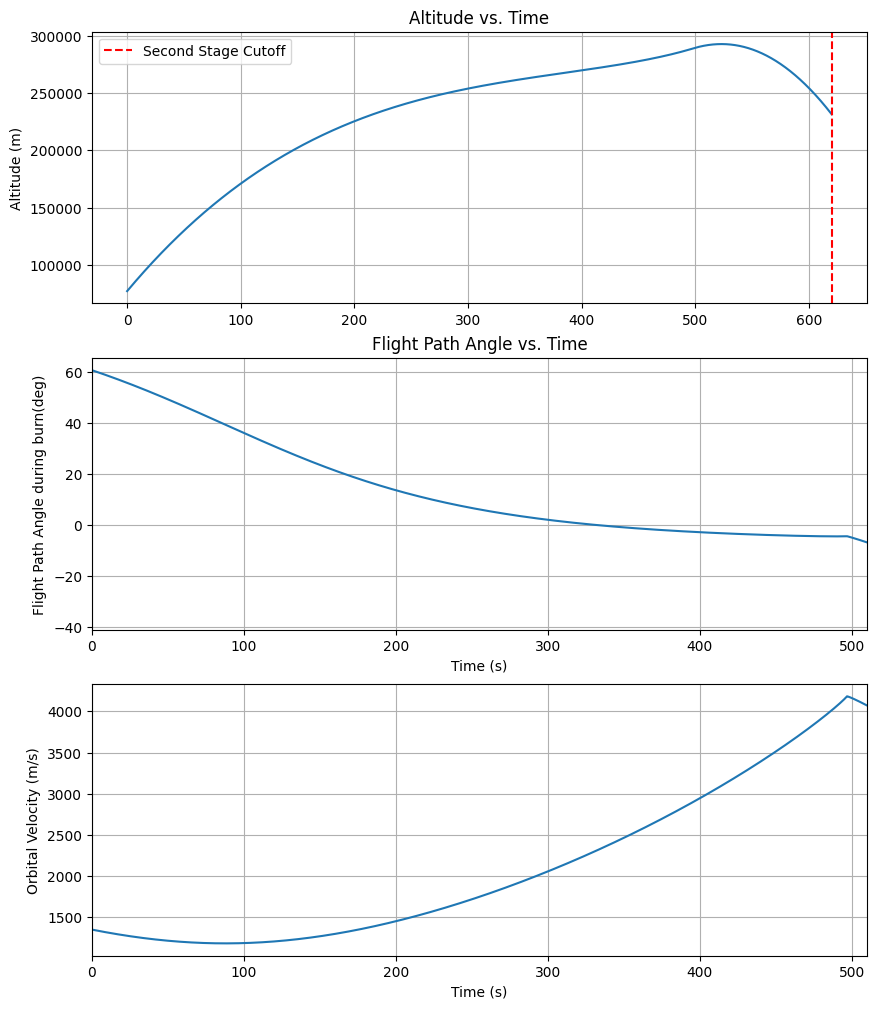

In [8]:
# The stage 2 position is at the point of booster cutoff, and we need to use that velocity vector as well.
pos_stage2_0 = pos_stage1[-1] + np.array([0, radius_earth])
vel_stage2_0 = vel_stage1[-1]  # Use the final velocity from stage 1

# Simulation parameters
n_steps_stage2 = int(burntime_stage2 / dt)            # simulate for 1 hour 

# Initialize the time array
t_stage2 = np.zeros(n_steps_stage2 + 1)  

# Set final pitch angle for stage 2
pitch_final_stage2 = 35

# Starship stage 2 parameters
mass2_0 = 1.2e6 # (kg)
v_ex2 = 3700
rv_mdot = 805
rv_mdot_total = rv_mdot * 3

# Initialize arrays for stage 2
pos_stage2 = np.zeros((n_steps_stage2+1, 2))
vel_stage2 = np.zeros((n_steps_stage2+1, 2))
acc_stage2 = np.zeros((n_steps_stage2+1, 2))
mass2 = np.zeros(n_steps_stage2 + 1)

# Set initial conditions for stage 2 from booster separation state
pos_stage2[0] = pos_stage2_0
vel_stage2[0] = vel_stage2_0
mass2[0] = mass2_0

# Earth's gravitational parameter
GM = 3.986004418e14  # [m^3/s^2]

# Main loop for orbital simulation
for i in range(n_steps_stage2):
    t_stage2[i+1] = t_stage2[i] + dt

    # Compute distance from Earth center using x and y coordinates
    r_vec = pos_stage2[i]
    r = np.linalg.norm(r_vec)

    # Gravitational acceleration as a function of distance
    grav_acc = (-GM / r**3 )*r_vec

    # Define pitch angle to start at booster separation and for another 45 until perpendicular with earth surface
    pitch_deg2 = pitch_final_stage1 + (pitch_final_stage2/burntime_stage2)*t_stage2[i]
    pitch_rad2 = np.deg2rad(pitch_deg2)

    # Define the radial unit vector
    r_hat = r_vec / r

    # Define a perpendicular unit vector
    perp_hat = np.array([r_hat[1], -r_hat[0]])

    # Compute thrust unit vector by measuring current angle from vertical
    thrust_unit = np.cos(pitch_rad2) * r_hat + np.sin(pitch_rad2) * perp_hat

    if t_stage2[i] < burntime_stage2:
        # Use the dot product of the velocity vector and the unit vector 
        # to determine the amount of thrust along the velocity vector
        thrust_along_v = np.dot(vel_stage2[i], thrust_unit)
        
        # Calculate acceleration from thrust
        thrust_acc2 = (rv_mdot_total / mass2[i]) * (v_ex2 - thrust_along_v)* thrust_unit

        # Update mass
        mass2[i+1] = mass2[i] - rv_mdot_total*dt
    
    else:
        thrust_acc2 = np.array([0.0,0.0])
        mass2[i+1] = mass2[i]

    acc_stage2[i] = thrust_acc2 + grav_acc

    # Update velocity and position
    vel_stage2[i+1] = vel_stage2[i] + acc_stage2[i]*dt
    pos_stage2[i+1] = pos_stage2[i] + vel_stage2[i]*dt + 0.5*acc_stage2[i]*dt**2



# Plot the orbital trajectory
plt.figure(figsize=(8, 8))
plt.plot(pos_stage2[:,0], pos_stage2[:,1], label='Orbital Trajectory')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Stage 2 Orbital Simulation')
plt.axis('equal')
plt.grid(True)

plt.legend()

# Draw a circle for Earth
theta = np.linspace(0, 2*np.pi, 100)
earth_x = radius_earth * np.cos(theta)
earth_y = radius_earth * np.sin(theta)
plt.plot(earth_x, earth_y, 'b-', label='Earth')
plt.legend()
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Altitude vs. time
axs[0].plot(t_stage2, np.linalg.norm(pos_stage2, axis=1) - radius_earth)
axs[0].set_ylabel('Altitude (m)')
axs[0].set_title('Altitude vs. Time')
axs[0].axvline(x=burntime_stage2, linestyle='--', color='red', label='Second Stage Cutoff')
axs[0].legend()
axs[0].grid(True)

# Flight angle vs. time
flight_angles2 = np.degrees(np.arctan2(vel_stage2[:,1], vel_stage2[:,0]))
axs[1].plot(t_stage2, flight_angles2)
axs[1].set_ylabel('Flight Path Angle during burn(deg)')
axs[1].set_xlabel('Time (s)')
axs[1].set_xlim(0,510)
axs[1].set_title('Flight Path Angle vs. Time')
axs[1].grid(True)

# Total orbital velocity vs. time
axs[2].plot(t_stage2, np.linalg.norm(vel_stage2, axis=1))
axs[2].set_ylabel('Orbital Velocity (m/s)')
axs[2].set_xlabel('Time (s)')
axs[2].grid()
axs[2].set_xlim(0,510)


Well that's not quite an orbit. The pitch angles are going to be a critical piece of the puzzle when determining the best trajectory, so next I'm going to piece together stage 1 and 2 calculations into a function that allows me to quickly adjust pitch angle parameters. I'll also calculate stage 1 in polar coordinates for consistency.

### Testing different trajectories

To model a typical gravity burn, I'll adjust the pitch rate over time using the function

$$\theta(t) = \frac{1}{1 + e^{-k\Delta t_{mid}} }$$
Where we are measuring $\Delta t_{mid} = \Delta t - \Delta t_{1/2\text{burn}}$ as the time from when the stage reaches halfway through its burn.

In [9]:
def simulate_launch(final_pitch_stage1, final_pitch_stage2):

    # --- Stage 1 Simulation ---
    n_steps_stage1 = int(burntime_stage1 / dt)
    
    # Initialize arrays
    t_stage1   = np.zeros(n_steps_stage1 + 1)
    m_stage1   = np.zeros(n_steps_stage1 + 1)
    pos_stage1 = np.zeros((n_steps_stage1 + 1, 2))
    vel_stage1 = np.zeros((n_steps_stage1 + 1, 2))
    acc_stage1 = np.zeros((n_steps_stage1 + 1, 2))
    
    # Initial conditions
    t_stage1[0] = 0.0
    pos_stage1[0] = np.array([0.0, radius_earth])
    vel_stage1[0] = np.array([v_rot, 0.0])
    m_stage1[0] = mass_total
    
    crashed = False
    
    # Start the loop for stage 1
    for i in range(n_steps_stage1):

        # Update time
        t_stage1[i+1] = t_stage1[i] + dt
        
        if crashed:
            break

        # Determine the local radial direction
        r_vec = pos_stage1[i]
        r = np.linalg.norm(r_vec)
        r_hat = r_vec / r
        
        if r<= radius_earth - 1:
            crashed = True
            break

        # Determine the perpendicular unit vector
        perp_hat = np.array([r_hat[1], -r_hat[0]])
        
        # Linearly vary the pitch angle from 0° to final pitch angle over the course of the burn time
        k=0.03

        T_mid = burntime_stage1 / 2
        delta_T_mid = t_stage1[i] - T_mid
        pitch_rate= 1 / (1+ np.exp(-k*delta_T_mid))
        pitch_deg = final_pitch_stage1 * pitch_rate
        pitch_rad = np.deg2rad(pitch_deg)

        # Calculate the thrust unit vector
        thrust_unit = np.cos(pitch_rad) * r_hat + np.sin(pitch_rad) * perp_hat
        
        # Calculate speed, altitude and air density
        speed = np.linalg.norm(vel_stage1[i])
        altitude = r - radius_earth
        air_density = rho * np.exp(-altitude / scale_height) if altitude < 120e3 else 0

        # Acceleration due to drag
        drag_acc = -0.5 * (air_density * drag_coef * cross_section / m_stage1[i]) * speed * vel_stage1[i]
        
        # Compute thrust acceleration during burn
        if t_stage1[i] < burntime_stage1:
            thrust_along_v = np.dot(vel_stage1[i], thrust_unit)
            thrust_acc = (mdot_stage1 / m_stage1[i]) * (v_exhaust_stage1 - thrust_along_v) * thrust_unit
            m_stage1[i+1] = m_stage1[i] - mdot_stage1 * dt
        else:
            thrust_acc = np.array([0.0, 0.0])
            m_stage1[i+1] = m_stage1[i]
        
        # Gravitational acceleration only in the radial direction
        grav_acc = (-GM / r**3) * pos_stage1[i]
        
        # Total acceleration
        acc_stage1[i] = thrust_acc + drag_acc + grav_acc
        
        # Euler integration for velocity and position
        vel_stage1[i+1] = vel_stage1[i] + acc_stage1[i] * dt
        pos_stage1[i+1] = pos_stage1[i] + vel_stage1[i] * dt + 0.5 * acc_stage1[i] * dt**2

    # --- Stage 2 Simulation ---
    # Use the final state from stage 1 as the starting condition
    pos_stage2_0 = pos_stage1[-1]
    vel_stage2_0 = vel_stage1[-1]
    
    n_steps_stage2 = int(burntime_stage2 / dt + 3600/dt) # simulate an extra hour after burntime 
    
    t_stage2 = np.zeros(n_steps_stage2 + 1)
    pos_stage2 = np.zeros((n_steps_stage2 + 1, 2))
    vel_stage2 = np.zeros((n_steps_stage2 + 1, 2))
    acc_stage2 = np.zeros((n_steps_stage2 + 1, 2))
    mass_stage2 = np.zeros(n_steps_stage2 + 1)
    
    t_stage2[0] = t_stage1[-1]
    pos_stage2[0] = pos_stage2_0
    vel_stage2[0] = vel_stage2_0
    mass_stage2[0] = mass_stage2_total
    

    # Loop for the second stage
    for i in range(n_steps_stage2):
        t_stage2[i+1] = t_stage2[i] + dt
        
        if crashed: 
            break

        # Determine the local radial direction
        r_vec = pos_stage2[i]
        r = np.linalg.norm(r_vec)
        r_hat = r_vec / r
        perp_hat = np.array([r_hat[1], -r_hat[0]])
        
        if r <= radius_earth - 1:
            crashed = True
            break

        # Vary the pitch angle of stage 2 in a different way
        k=0.03

        T_mid_stage2 = burntime_stage2 / 2
        delta_T_mid_stage2 = t_stage2[i] - T_mid_stage2
        pitch_rate2= 1 / (1+ np.exp(-k*delta_T_mid_stage2))
        pitch_deg2 = final_pitch_stage2 * pitch_rate2
        pitch_rad2 = np.deg2rad(pitch_deg2)
        
        thrust_unit = np.cos(pitch_rad2) * r_hat + np.sin(pitch_rad2) * perp_hat
        
        # Gravitational acceleration
        grav_acc = (-GM / r**3) * pos_stage2[i]
        
        # Thrust acceleration during burn time, making sure to use t-t0 for the burntime check
        if (t_stage2[i] - t_stage1[-1]) < burntime_stage2:
            thrust_along_v = np.dot(vel_stage2[i], thrust_unit)
            thrust_acc2 = (mdot_stage2 / mass_stage2[i]) * (v_exhaust_stage2 - thrust_along_v) * thrust_unit
            mass_stage2[i+1] = mass_stage2[i] - mdot_stage2 * dt
        else:
            thrust_acc2 = np.array([0.0, 0.0])
            mass_stage2[i+1] = mass_stage2[i]
       
        # Update the acceleration, velocity and position
        acc_stage2[i] = thrust_acc2 + grav_acc
        vel_stage2[i+1] = vel_stage2[i] + acc_stage2[i] * dt
        pos_stage2[i+1] = pos_stage2[i] + vel_stage2[i] * dt + 0.5 * acc_stage2[i] * dt**2

        
    # Make dataframes for the two stages
    df_stage1 = pd.DataFrame({
        'stage': ['stage1'] * (n_steps_stage1 + 1),
        'time': t_stage1,
        'pos_x': pos_stage1[:, 0],
        'pos_y': pos_stage1[:, 1],
        'r': np.sqrt(pos_stage1[:, 0]**2 + pos_stage1[:, 1]**2),  # Radial distance from Earth's center
        'theta_deg': np.degrees(np.arctan2(pos_stage1[:, 1], pos_stage1[:, 0])),  # Angle in degrees
        'vel_x': vel_stage1[:, 0],
        'vel_y': vel_stage1[:, 1],
        'vel_orb': np.sqrt(vel_stage1[:,0]**2 + vel_stage1[:,1]**2),
        'acc_x': acc_stage1[:, 0],
        'acc_y': acc_stage1[:, 1],
        'mass': m_stage1
    })
    df_stage2 = pd.DataFrame({
        'stage': ['stage2'] * (n_steps_stage2 + 1),
        'time': t_stage2,
        'pos_x': pos_stage2[:, 0],
        'pos_y': pos_stage2[:, 1],
        'r': np.sqrt(pos_stage2[:, 0]**2 + pos_stage2[:, 1]**2),
        'theta_deg': np.degrees(np.arctan2(pos_stage2[:, 1], pos_stage2[:, 0])),  
        'vel_x': vel_stage2[:, 0],
        'vel_y': vel_stage2[:, 1],
        'vel_orb': np.sqrt(vel_stage2[:,0]**2 + vel_stage2[:,1]**2),
        'acc_x': acc_stage2[:, 0],
        'acc_y': acc_stage2[:, 1],
        'mass': mass_stage2
    })

    df = pd.concat([df_stage1, df_stage2], ignore_index=True)
    return df



In [10]:
launch_results_20_30 = simulate_launch(20,30)
launch_results_20_40 = simulate_launch(20,40)
launch_results_30_50 = simulate_launch(30,50)
launch_results_70_85 = simulate_launch(70,85)

C:\Users\smick\AppData\Local\Temp\ipykernel_37548\1640392658.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(theta_earth, earth_r, 'b-', linestyle='--', label='Earth')


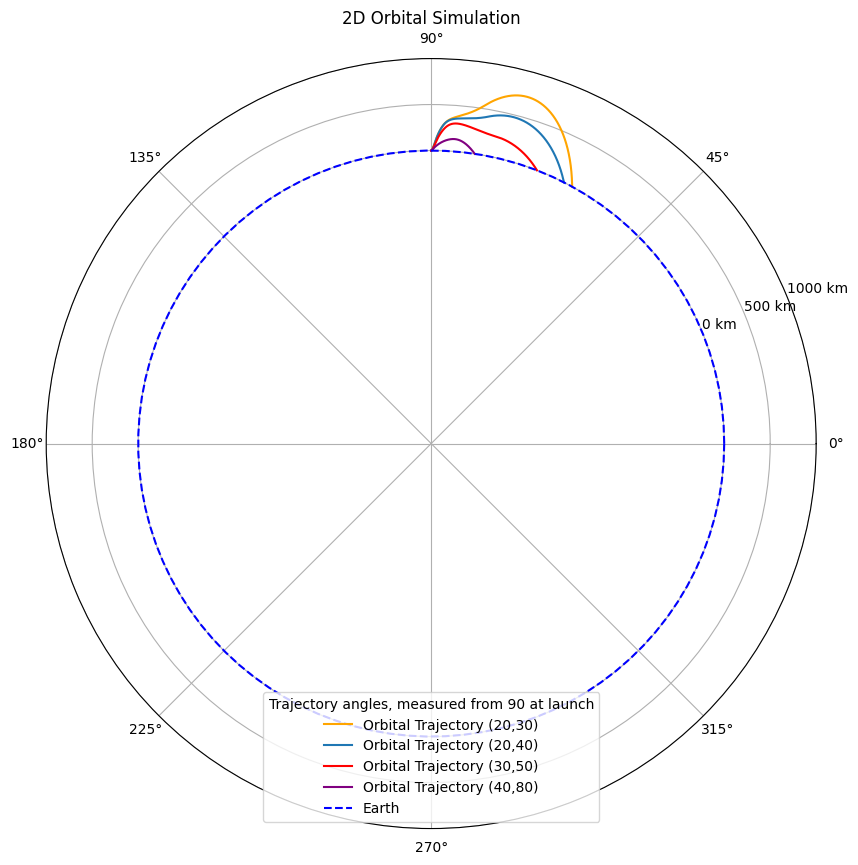

In [11]:
# Create a figure and a polar axis
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': 'polar'})

# Plot each trajectory with filtered theta values
ax.plot(np.deg2rad(launch_results_20_30['theta_deg']), launch_results_20_30['r'], 
        color='orange', label='Orbital Trajectory (20,30)')
ax.plot(np.deg2rad(launch_results_20_40['theta_deg']), launch_results_20_40['r'], 
        label='Orbital Trajectory (20,40)')
ax.plot(np.deg2rad(launch_results_30_50['theta_deg']), launch_results_30_50['r'], 
        color='red', label='Orbital Trajectory (30,50)')
ax.plot(np.deg2rad(launch_results_70_85['theta_deg']), launch_results_70_85['r'], 
        color='purple', label='Orbital Trajectory (40,80)')

# Draw a circle for Earth
theta_earth = np.linspace(0, 2*np.pi, 100)
earth_r = radius_earth * np.ones_like(theta_earth)
ax.plot(theta_earth, earth_r, 'b-', linestyle='--', label='Earth')

# Limit theta to 180° to 0°
#ax.set_thetalim(np.deg2rad(180), np.deg2rad(0))

# Configure radial axis ticks:
altitude_max = 1000e3    # 1000 km in meters
step = 500e3              # 50 km in meters

# Create ticks from Earth's surface to Earth + 1000 km
radial_ticks = np.arange(radius_earth, radius_earth + altitude_max + step, step)

# Set the radial limit so that only altitudes up to 1000 km are shown.
ax.set_ylim(0.5*radius_earth, radius_earth + altitude_max)

# Use set_rticks (preferred for polar axes) to set the ticks.
ax.set_rticks(radial_ticks)

# Label the ticks as altitude above Earth's surface in km
ax.set_yticklabels([f"{(r - radius_earth)/1000:.0f} km" for r in radial_ticks])

# Set title and legend
ax.set_title('2D Orbital Simulation')
ax.legend(title='Trajectory angles, measured from 90 at launch', loc='lower center')
ax.grid(True)

plt.show()

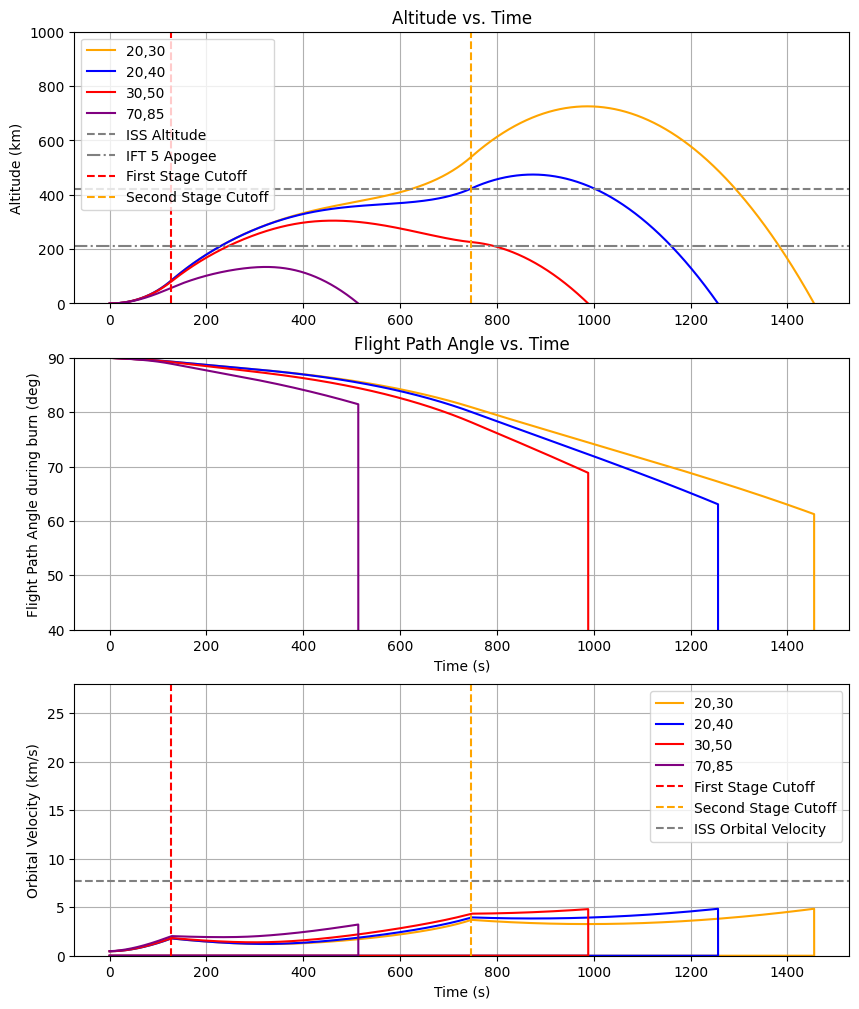

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
import matplotlib.ticker as mticker

# Altitude vs. time
axs[0].plot(launch_results_20_30['time'], (launch_results_20_30['r']-radius_earth), color='orange', label='20,30')
axs[0].plot(launch_results_20_40['time'], (launch_results_20_40['r']-radius_earth), color='blue', label='20,40')
axs[0].plot(launch_results_30_50['time'], (launch_results_30_50['r']-radius_earth), color='red', label='30,50')
axs[0].plot(launch_results_70_85['time'], (launch_results_70_85['r']-radius_earth), color='purple', label='70,85')
axs[0].set_ylim(0,1e6)
axs[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x/1000:.0f}"))
axs[0].set_ylabel('Altitude (km)')
axs[0].set_title('Altitude vs. Time')
axs[0].axhline(y=420e3, linestyle='--', color='grey', label='ISS Altitude')
axs[0].axhline(y=213e3, linestyle='-.', color='grey', label='IFT 5 Apogee')
axs[0].axvline(x=(burntime_stage1), linestyle='--', color='red', label='First Stage Cutoff')
axs[0].axvline(x=(burntime_stage2+burntime_stage1), linestyle='--', color='orange', label='Second Stage Cutoff')
axs[0].legend()
axs[0].grid(True)

# Flight angle vs. time
axs[1].plot(launch_results_20_30['time'], (launch_results_20_30['theta_deg']), color='orange', label='20,30')
axs[1].plot(launch_results_20_40['time'], (launch_results_20_40['theta_deg']), color='blue', label='20,40')
axs[1].plot(launch_results_30_50['time'], (launch_results_30_50['theta_deg']), color='red', label='30,50')
axs[1].plot(launch_results_70_85['time'], (launch_results_70_85['theta_deg']), color='purple', label='70,85')
axs[1].set_ylim(40,90)
axs[1].set_ylabel('Flight Path Angle during burn (deg)')
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Flight Path Angle vs. Time')
axs[1].grid(True)

# Total orbital velocity vs. time
axs[2].plot(launch_results_20_30['time'], (launch_results_20_30['vel_orb']), color='orange', label='20,30')
axs[2].plot(launch_results_20_40['time'], (launch_results_20_40['vel_orb']), color='blue', label='20,40')
axs[2].plot(launch_results_30_50['time'], (launch_results_30_50['vel_orb']), color='red', label='30,50')
axs[2].plot(launch_results_70_85['time'], (launch_results_70_85['vel_orb']), color='purple', label='70,85')
axs[2].set_ylabel('Orbital Velocity (km/s)')
axs[2].set_xlabel('Time (s)')
axs[2].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, vel_orb: f"{x/1000:.0f}"))
axs[2].grid(True)
axs[2].axvline(x=(burntime_stage1), linestyle='--', color='red', label='First Stage Cutoff')
axs[2].axvline(x=(burntime_stage2+burntime_stage1), linestyle='--', color='orange', label='Second Stage Cutoff')
axs[2].axhline(y=iss_vel_orb, linestyle='--', color='grey', label='ISS Orbital Velocity')
axs[2].legend()
axs[2].set_ylim(0,28000)

plt.show()
